In [268]:
%matplotlib inline


# Classification of spoken digit recordings

In this example we use the 1D scattering transform to represent spoken digits,
which we then classify using a simple classifier. This shows that 1D scattering
representations are useful for this type of problem.

This dataset is automatically downloaded and preprocessed from
https://github.com/Jakobovski/free-spoken-digit-dataset.git

Downloading and precomputing scattering coefficients should take about 5 min.
Running the gradient descent takes about 1 min.

Results:
Training accuracy = 99.7%
Testing accuracy = 98.0%


## Preliminaries

Since we're using PyTorch to train the model, import `torch`.



In [274]:
import torch

We will be constructing a logistic regression classifier on top of the
scattering coefficients, so we need some of the neural network tools from
`torch.nn` and the Adam optimizer from `torch.optim`.



In [275]:
from torch.nn import Linear, NLLLoss, LogSoftmax, Sequential
from torch.optim import Adam

To handle audio file I/O, we import `os` and `scipy.io.wavfile`. We also need
`numpy` for some basic array manipulation.



In [276]:
from scipy.io import wavfile
import os
import numpy as np

To evaluate our results, we need to form a confusion matrix using
scikit-learn and display them using `matplotlib`.



In [307]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Finally, we import the `Scattering1D` class from the `kymatio.torch` package
and the `fetch_fsdd` function from `kymatio.datasets`. The `Scattering1D`
class is what lets us calculate the scattering transform, while the
`fetch_fsdd` function downloads the FSDD, if needed.



In [278]:
from kymatio.torch import Scattering1D
from kymatio.datasets import fetch_fsdd

## Pipeline setup
We start by specifying the dimensions of our processing pipeline along with
some other parameters.

First, we have signal length. Longer signals are truncated and shorter
signals are zero-padded. The sampling rate is 8000 Hz, so this corresponds to
little over a second.



In [279]:
T = 2**13

Maximum scale 2**J of the scattering transform (here, about 30 milliseconds)
and the number of wavelets per octave.



In [280]:
J = 8
Q = 12

We need a small constant to add to the scattering coefficients before
computing the logarithm. This prevents very large values when the scattering
coefficients are very close to zero.



In [281]:
log_eps = 1e-6

If a GPU is available, let's use it!



In [282]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

For reproducibility, we fix the seed of the random number generator.



In [283]:
torch.manual_seed(42)

## Loading the data
Once the parameter are set, we can start loading the data into a format that
can be fed into the scattering transform and then a logistic regression
classifier.

We first download the dataset. If it's already downloaded, `fetch_fsdd` will
simply return the information corresponding to the dataset that's already
on disk.



In [12]:
info_data = fetch_fsdd()
files = info_data['files']
path_dataset = info_data['path_dataset']

Set up Tensors to hold the audio signals (`x_all`), the labels (`y_all`), and
whether the signal is in the train or test set (`subset`).



In [18]:
x_all = torch.zeros(len(files), T, dtype=torch.float32, device=device)
y_all = torch.zeros(len(files), dtype=torch.int64, device=device)
subset = torch.zeros(len(files), dtype=torch.int64, device=device)

For each file in the dataset, we extract its label `y` and its index from the
filename. If the index is between 0 and 4, it is placed in the test set, while
files with larger indices are used for training. The actual signals are
normalized to have maximum amplitude one, and are truncated or zero-padded
to the desired length `T`. They are then stored in the `x_all` Tensor while
their labels are in `y_all`.



In [19]:
for k, f in enumerate(files):
    basename = f.split('.')[0]

    # Get label (0-9) of recording.
    y = int(basename.split('_')[0])

    # Index larger than 5 gets assigned to training set.
    if int(basename.split('_')[2]) >= 5:
        subset[k] = 0
    else:
        subset[k] = 1

    # Load the audio signal and normalize it.
    _, x = wavfile.read(os.path.join(path_dataset, f))
    x = np.asarray(x, dtype='float')
    x /= np.max(np.abs(x))

    # Convert from NumPy array to PyTorch Tensor.
    x = torch.from_numpy(x).to(device)

    # If it's too long, truncate it.
    if x.numel() > T:
        x = x[:T]

    # If it's too short, zero-pad it.
    start = (T - x.numel()) // 2

    x_all[k,start:start + x.numel()] = x
    y_all[k] = y

## Log-scattering transform
We now create the `Scattering1D` object that will be used to calculate the
scattering coefficients.



In [27]:
scattering = Scattering1D(J, T, Q).to(device)

Compute the scattering transform for all signals in the dataset.



In [28]:
Sx_all = scattering.forward(x_all)

Since it does not carry useful information, we remove the zeroth-order
scattering coefficients, which are always placed in the first channel of
the scattering Tensor.



In [29]:
Sx_all = Sx_all[:,1:,:]

To increase discriminability, we take the logarithm of the scattering
coefficients (after adding a small constant to make sure nothing blows up
when scattering coefficients are close to zero). This is known as the
log-scattering transform.



In [30]:
Sx_all = torch.log(torch.abs(Sx_all) + log_eps)

Finally, we average along the last dimension (time) to get a time-shift
invariant representation.



In [31]:
Sx_all = torch.mean(Sx_all, dim=-1)

## Training the classifier
With the log-scattering coefficients in hand, we are ready to train our
logistic regression classifier.

First, we extract the training data (those for which `subset` equals `0`)
and the associated labels.



In [32]:
Sx_tr, y_tr = Sx_all[subset == 0], y_all[subset == 0]

Standardize the data to have mean zero and unit variance. Note that we need
to apply the same transformation to the test data later, so we save the
mean and standard deviation Tensors.



In [33]:
mu_tr = Sx_tr.mean(dim=0)
std_tr = Sx_tr.std(dim=0)
Sx_tr = (Sx_tr - mu_tr) / std_tr

Here we define a logistic regression model using PyTorch. We train it using
Adam with a negative log-likelihood loss.



In [34]:
num_input = Sx_tr.shape[-1]
num_classes = y_tr.cpu().unique().numel()
model = Sequential(Linear(num_input, num_classes), LogSoftmax(dim=1))
optimizer = Adam(model.parameters())
criterion = NLLLoss()

If we're on a GPU, transfer the model and the loss function onto the device.



In [35]:
model = model.to(device)
criterion = criterion.to(device)

Before training the model, we set some parameters for the optimization
procedure.



In [36]:
# Number of signals to use in each gradient descent step (batch).
batch_size = 32
# Number of epochs.
num_epochs = 50
# Learning rate for Adam.
lr = 1e-4

Given these parameters, we compute the total number of batches.



In [37]:
nsamples = Sx_tr.shape[0]
nbatches = nsamples // batch_size

Now we're ready to train the classifier.



In [38]:
for e in range(num_epochs):
    # Randomly permute the data. If necessary, transfer the permutation to the
    # GPU.
    perm = torch.randperm(nsamples, device=device)

    # For each batch, calculate the gradient with respect to the loss and take
    # one step.
    for i in range(nbatches):
        idx = perm[i * batch_size : (i+1) * batch_size]
        model.zero_grad()
        resp = model.forward(Sx_tr[idx])
        loss = criterion(resp, y_tr[idx])
        loss.backward()
        optimizer.step()

    # Calculate the response of the training data at the end of this epoch and
    # the average loss.
    resp = model.forward(Sx_tr)
    avg_loss = criterion(resp, y_tr)

    # Try predicting the classes of the signals in the training set and compute
    # the accuracy.
    y_hat = resp.argmax(dim=1)
    accuracy = (y_tr == y_hat).float().mean()

    print('Epoch {}, average loss = {:1.3f}, accuracy = {:1.3f}'.format(
        e, avg_loss, accuracy))

Epoch 0, average loss = 0.732, accuracy = 0.826
Epoch 1, average loss = 0.515, accuracy = 0.880
Epoch 2, average loss = 0.408, accuracy = 0.906
Epoch 3, average loss = 0.350, accuracy = 0.916
Epoch 4, average loss = 0.316, accuracy = 0.922
Epoch 5, average loss = 0.282, accuracy = 0.931
Epoch 6, average loss = 0.258, accuracy = 0.941
Epoch 7, average loss = 0.241, accuracy = 0.943
Epoch 8, average loss = 0.221, accuracy = 0.951
Epoch 9, average loss = 0.209, accuracy = 0.951
Epoch 10, average loss = 0.196, accuracy = 0.957
Epoch 11, average loss = 0.188, accuracy = 0.959
Epoch 12, average loss = 0.177, accuracy = 0.961
Epoch 13, average loss = 0.169, accuracy = 0.963
Epoch 14, average loss = 0.159, accuracy = 0.965
Epoch 15, average loss = 0.155, accuracy = 0.966
Epoch 16, average loss = 0.146, accuracy = 0.969
Epoch 17, average loss = 0.142, accuracy = 0.970
Epoch 18, average loss = 0.137, accuracy = 0.970
Epoch 19, average loss = 0.133, accuracy = 0.969
Epoch 20, average loss = 0.129

Now that our network is trained, let's test it!

First, we extract the test data (those for which `subset` equals `1`) and the
associated labels.



In [39]:
Sx_te, y_te = Sx_all[subset == 1], y_all[subset == 1]

Use the mean and standard deviation calculated on the training data to
standardize the testing data, as well.



In [40]:
Sx_te = (Sx_te - mu_tr) / std_tr

Calculate the response of the classifier on the test data and the resulting
loss.



In [41]:
resp = model.forward(Sx_te)
avg_loss = criterion(resp, y_te)

# Try predicting the labels of the signals in the test data and compute the
# accuracy.

y_hat = resp.argmax(dim=1)
accu = (y_te == y_hat).float().mean()

print('TEST, average loss = {:1.3f}, accuracy = {:1.3f}'.format(
      avg_loss, accu))

TEST, average loss = 0.129, accuracy = 0.957


## Plotting the classification accuracy as a confusion matrix
Let's see what the very few misclassified sounds get misclassified as. We
will plot a confusion matrix which indicates in a 2D histogram how often
one sample was mistaken for another (anything on the diagonal is correctly
classified, anything off the diagonal is wrong).



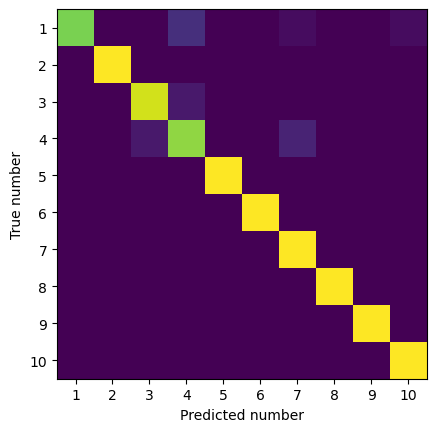

In [42]:
predicted_categories = y_hat.cpu().numpy()
actual_categories = y_te.cpu().numpy()

confusion = confusion_matrix(actual_categories, predicted_categories)
plt.figure()
plt.imshow(confusion)
tick_locs = np.arange(10)
ticks = ['{}'.format(i) for i in range(1, 11)]
plt.xticks(tick_locs, ticks)
plt.yticks(tick_locs, ticks)
plt.ylabel("True number")
plt.xlabel("Predicted number")
plt.show()

Print the confusion matrix explicitly

In [43]:
confusion

array([[24,  0,  0,  4,  0,  0,  1,  0,  0,  1],
       [ 0, 30,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 28,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2, 25,  0,  0,  3,  0,  0,  0],
       [ 0,  0,  0,  0, 30,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 30,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 30,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 30,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 30,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 30]])

# Repeat the classifications with different audio signals

In [352]:
from os import listdir
import IPython.display as ipd
from librosa.effects import trim

In [285]:
path='archive/audio/audio/'
ds_files = listdir(path)
ds_files.remove('44100')
ds_files.remove('16000')

In [286]:
x_all = torch.zeros(len(ds_files), T, dtype=torch.float32, device=device)
y_all = torch.zeros(len(ds_files), dtype=torch.int64, device=device)
subset = torch.zeros(len(ds_files), dtype=torch.int64, device=device)

## Some EDA

In [287]:
rate, data = wavfile.read(os.path.join(path, ds_files[1]))
rate

44100

In [346]:
x_array=[]
for k, f in enumerate(ds_files):
    _, x = wavfile.read(os.path.join(path, f))
    x = np.asarray(x, dtype='float')
    x /= np.max(np.abs(x))
    x_array.append(x)

Text(0, 0.5, 'count')

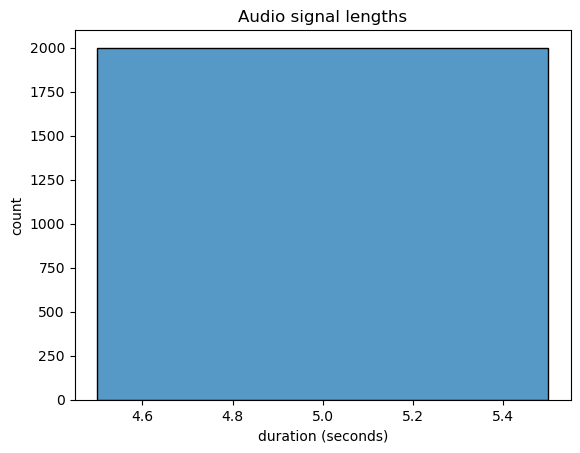

In [350]:
# we print the different lengths of the signals (normalised by the rate)
lens=[]
for data in x_array:
    lens.append(len(data)/rate)

title = 'Audio signal lengths'
x_label = 'duration (seconds)'
y_label = 'count'

plt=sns.histplot(lens)
plt.set_title(title)
plt.set_xlabel(x_label)
plt.set_ylabel(y_label)

In [1]:
# histogram of the trimmed data
lens=[]
x_trimmed=[]
for data in x_array:
    data_trimmed, _ =trim(np.array(data, dtype = np.float64),top_db=10)
    x_trimmed.append(np.asarray(data_trimmed))
    lens.append(len(data_trimmed)/rate)
title = 'Audio signal lengths'
x_label = 'duration (seconds)'
y_label = 'count'

plt=sns.histplot(lens)
plt.set_title(title)
plt.set_xlabel(x_label)
plt.set_ylabel(y_label)

NameError: name 'x_array' is not defined

In [398]:
print(len(x_array[45]))
print(len(x_trimmed[45]))
type(x_trimmed)

220500
179200


numpy.ndarray

In [396]:
#x_trimmed=np.array(x_trimmed)
for k, f in enumerate(ds_files):
    basename = f.split('-')

    # Get label (0-50) of recording.
    y = int(basename[-1].split('.')[0])

    # Index larger than 5 gets assigned to training set.
    if int(basename[0]) < 5:
        subset[k] = 0
    else:
        subset[k] = 1
    # Load the audio signal and normalize it.
    #_, x = wavfile.read(os.path.join(path, f))
    #x = np.asarray(x, dtype='float')
    #x /= np.max(np.abs(x))
    # Convert from NumPy array to PyTorch Tensor.
    x_trimmed = torch.from_numpy(x_trimmed).to(device)

    # If it's too long, truncate it.
    if x_trimmed.numel() > T:
        x_trimmed = x_trimmed[:T]

    # If it's too short, zero-pad it.
    start = (T - x_trimmed.numel()) // 2

    x_all[k,start:start + x_trimmed.numel()] = x_trimmed
    y_all[k] = y

   

/tmp/ipykernel_65055/3263503142.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_trimmed=np.array(x_trimmed)


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [373]:
scattering = Scattering1D(J, T, Q).to(device)
Sx_all = scattering.forward(x_all)    

In [374]:
len(Sx_all[0])

337

In [375]:
#eliminate the zeroth-order coefficient
Sx_all = Sx_all[:,1:,:]

Sx_all = torch.log(torch.abs(Sx_all) + log_eps)
Sx_all = torch.mean(Sx_all, dim=-1)

In [376]:
Sx_tr, y_tr = Sx_all[subset == 0], y_all[subset == 0]

In [377]:
mu_tr = Sx_tr.mean(dim=0)
std_tr = Sx_tr.std(dim=0)
Sx_tr = (Sx_tr - mu_tr) / std_tr

In [378]:
num_input = Sx_tr.shape[-1]
num_classes = y_tr.cpu().unique().numel()
model = Sequential(Linear(num_input, num_classes), LogSoftmax(dim=1))
optimizer = Adam(model.parameters())
criterion = NLLLoss()

In [379]:
model = model.to(device)
criterion = criterion.to(device)

In [380]:
# Number of signals to use in each gradient descent step (batch).
batch_size = 32
# Number of epochs.
num_epochs = 50
# Learning rate for Adam.
lr = 1e-4

In [381]:
nsamples = Sx_tr.shape[0]
nbatches = nsamples // batch_size

In [382]:
for e in range(num_epochs):
    # Randomly permute the data. If necessary, transfer the permutation to the
    # GPU.
    perm = torch.randperm(nsamples, device=device)

    # For each batch, calculate the gradient with respect to the loss and take
    # one step.
    for i in range(nbatches):
        idx = perm[i * batch_size : (i+1) * batch_size]
        model.zero_grad()
        resp = model.forward(Sx_tr[idx])
        loss = criterion(resp, y_tr[idx])
        loss.backward()
        optimizer.step()

    # Calculate the response of the training data at the end of this epoch and
    # the average loss.
    resp = model.forward(Sx_tr)
    avg_loss = criterion(resp, y_tr)

    # Try predicting the classes of the signals in the training set and compute
    # the accuracy.
    y_hat = resp.argmax(dim=1)
    accuracy = (y_tr == y_hat).float().mean()

    print('Epoch {}, average loss = {:1.3f}, accuracy = {:1.3f}'.format(
        e, avg_loss, accuracy))

Epoch 0, average loss = nan, accuracy = 0.020
Epoch 1, average loss = nan, accuracy = 0.020
Epoch 2, average loss = nan, accuracy = 0.020
Epoch 3, average loss = nan, accuracy = 0.020
Epoch 4, average loss = nan, accuracy = 0.020
Epoch 5, average loss = nan, accuracy = 0.020
Epoch 6, average loss = nan, accuracy = 0.020
Epoch 7, average loss = nan, accuracy = 0.020
Epoch 8, average loss = nan, accuracy = 0.020
Epoch 9, average loss = nan, accuracy = 0.020
Epoch 10, average loss = nan, accuracy = 0.020
Epoch 11, average loss = nan, accuracy = 0.020
Epoch 12, average loss = nan, accuracy = 0.020
Epoch 13, average loss = nan, accuracy = 0.020
Epoch 14, average loss = nan, accuracy = 0.020
Epoch 15, average loss = nan, accuracy = 0.020
Epoch 16, average loss = nan, accuracy = 0.020
Epoch 17, average loss = nan, accuracy = 0.020
Epoch 18, average loss = nan, accuracy = 0.020
Epoch 19, average loss = nan, accuracy = 0.020
Epoch 20, average loss = nan, accuracy = 0.020
Epoch 21, average loss 

In [301]:
Sx_te, y_te = Sx_all[subset == 1], y_all[subset == 1]
Sx_te = (Sx_te - mu_tr) / std_tr

In [302]:
resp = model.forward(Sx_te)
avg_loss = criterion(resp, y_te)

# Try predicting the labels of the signals in the test data and compute the
# accuracy.

y_hat = resp.argmax(dim=1)
accu = (y_te == y_hat).float().mean()

print('TEST, average loss = {:1.3f}, accuracy = {:1.3f}'.format(
      avg_loss, accu))

TEST, average loss = 2.978, accuracy = 0.260


Plotting the confusion matrix

In [ ]:
#this needs to be re-run just before we plot the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

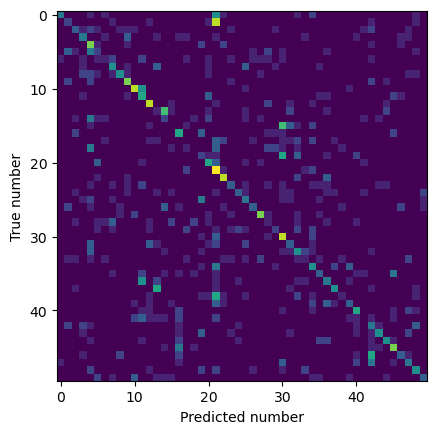

In [308]:
predicted_categories = y_hat.cpu().numpy()
actual_categories = y_te.cpu().numpy()

confusion = confusion_matrix(actual_categories, predicted_categories)
plt.figure()
plt.imshow(confusion)
#tick_locs = np.arange(50)
#ticks = ['{}'.format(i) for i in range(1, 51)]
#plt.xticks(tick_locs, ticks)
#plt.yticks(tick_locs, ticks)
plt.ylabel("True number")
plt.xlabel("Predicted number")
plt.show()

In [336]:
x_array
_, x = wavfile.read(os.path.join(path, ds_files[300]))
_, y = wavfile.read(os.path.join(path, ds_files[301]))
_, z = wavfile.read(os.path.join(path, ds_files[78]))
x = np.asarray(x, dtype='float')
x /= np.max(np.abs(x))
y = np.asarray(y, dtype='float')
y /= np.max(np.abs(y))
z = np.asarray(z, dtype='float')
z /= np.max(np.abs(z))

In [335]:
ds_files.index('1-187207-A-20.wav',)

78

In [340]:
ipd.Audio(x_array[34], rate=44100)

/home/fsarandrea/anaconda3/envs/tf/lib/python3.10/site-packages/IPython/lib/display.py:187: RuntimeWarning: invalid value encountered in divide
  scaled = data / normalization_factor * 32767


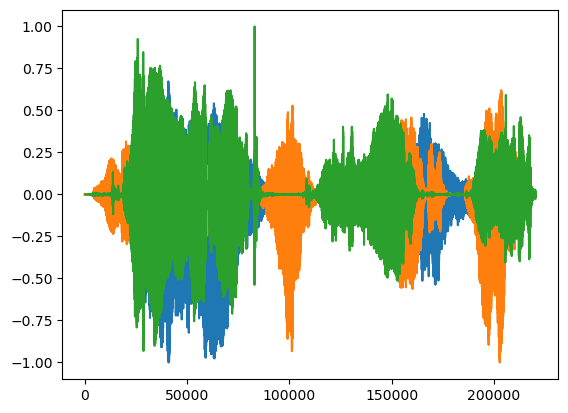

In [339]:
plt.plot(x)
plt.plot(y)
plt.plot(z)
plt.show()